<a href="https://colab.research.google.com/github/Rajit13/My-Research-Works/blob/main/Durbin_shuvorat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Basics import library

import numpy as np
import astropy.coordinates as co
from astropy import units as u
from astropy.time import Time
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta


## Best time day

This function, `best_times_day`, is designed to calculate and visualize various astronomical aspects related to a given celestial coordinate (presumably in Right Ascension and Declination). Here's an organized breakdown of what the code accomplishes:

### Function Purpose:
- Determines the best times of the day for observing a celestial target while considering the positions of the Sun, Moon, and optionally, satellite separations.

### Parameters:
- `coord`: Celestial coordinate (presumably Right Ascension and Declination)
- `lat`, `lon`: Latitude and longitude of the observer (default values correspond to an observatory in Australia)
- `utcoff`: UTC offset in hours (default is +2 hours)
- `date`: Date for which observations are calculated (default is January 1, 2019)
- `plot`: Boolean indicating whether to generate a plot (default is True)
- `show`: Boolean indicating whether to display the plot (default is False)
- Other parameters relate to specific plotting and observational settings.

### Process Overview:
1. Sets up the observer's location and timeframes for observation.
2. Calculates the positions of the Sun, Moon, and the specified celestial target at different times.
3. Identifies various conditions, such as solar and lunar separations, target altitude constraints, and day/night intervals.
4. Optionally calculates satellite separations if `satellites` is set to True.
5. Generates a plot showing the altitude of the Sun, Moon, and the target throughout the day. If satellite tracking is enabled, it displays satellite separations.

### Notes:
- The code performs calculations using astropy (`co`) and numpy (`np`) libraries.
- Error handling (`try`, `except`) is utilized for specific sections that might encounter issues.
- The function can either display the plot (`show=True`) or save it as an image file.

The function seems to be tailored for astronomical observation planning, allowing users to visualize optimal observation times considering the positions of celestial bodies and potential satellite interference.

In [11]:
def best_times_day(coord, lat=24.3746, lon=88.6004, utcoff=2., date='2023-11-21', plot=True, show=False,
                   distsun=5, distmoon=3, elev=10, night=False, leg=None, setrise=True,
                   filename='auspicious_day.png', satellites=False):

    # Set up observer's location and parameters
    location = co.EarthLocation(lat=lat*u.deg, lon=lon*u.deg, height=1e3*u.m)
    utcoffset = utcoff*u.hour
    timesteps = 120
    delta_time = np.linspace(-12, 12, timesteps) * u.hour
    ind = range(0, len(delta_time))

    # Calculate timeframes for observation
    midnight = Time(date) - utcoffset
    times = midnight + delta_time
    frame = co.AltAz(obstime=times, location=location)

    # Transform coordinates to the specified frame
    sun = co.get_sun(times).transform_to(frame)
    moon = co.get_moon(times).transform_to(frame)
    src = coord.transform_to(frame)

    # Identify various conditions for observation
    ind_riseset = np.where(np.logical_and(sun.alt > -12*u.deg, sun.alt < 12*u.deg))[0]
    ind_sun = np.where(src.separation(sun).deg < distsun)[0]
    ind_moon = np.where(src.separation(moon).deg < distmoon)[0]
    alt_max = src.alt.max()
    ind_low = np.where(src.alt <= (alt_max - alt_max * (elev / 100.)))[0]

    # Check for day or night observation
    if night == True:
        ind_day = np.where(sun.alt > 0*u.deg)[0]
    else:
        ind_day = [None]

    # Calculate best time for observation by eliminating conflicting conditions
    g = np.sort(list(set(ind) - set(ind_riseset) - set(ind_sun) - set(ind_moon) - set(ind_low) - set(ind_day)))
    try:
        tg = delta_time[g]
    except:
        tg = None

    # Calculate satellite separations if requested
    if satellites:
        print("Calculating satellite separations")
        sat_times = [(times[g][0] + i*u.minute).datetime for i in range(int((tg[-1] - tg[0]).to(u.minute) / u.minute))]
        params = [list(i) for i in zip([[coord.ra.rad, coord.dec.rad] for i in range(len(sat_times))], sat_times)]
        min_seps = np.nanmin(np.array(parmap(sat_separations, params)), axis=1)
        sat_time_steps = np.linspace(delta_time[g][0], delta_time[g][-1], len(min_seps))
        sat_frame = co.AltAz(obstime=sat_times, location=location)
        sat_alts = coord.transform_to(sat_frame).alt

    # Generate plot if required
    if plot == True:
        plt.plot(delta_time, sun.alt, 'r--', label='Sun')
        plt.plot(delta_time, moon.alt, 'b--', label='Moon')
        plt.fill_between(delta_time.to('hr').value, 0, 90, np.logical_and(sun.alt < 12*u.deg, sun.alt > -12*u.deg),
                         color='0.5', alpha=0.5)
        plt.fill_between(delta_time.to('hr').value, 0, 90, sun.alt < 0*u.deg, color='0.9', alpha=0.7)
        plt.plot(delta_time, src.alt, 'g-', label='Target')

        # Plot satellite separations if calculated
        if satellites:
            try:
                cb = plt.scatter(sat_time_steps, sat_alts, c=min_seps, s=30, alpha=0.5, vmin=0, vmax=10)
            except:
                None
        else:
            try:
                plt.scatter(delta_time[g], src.alt[g], s=30, c='g', alpha=0.5, label='Best time')
            except:
                None

        # Set plot parameters
        plt.ylim(0, 90)
        plt.xlim(-12, 12)
        plt.xticks(range(-12, 13, 2))
        plt.legend(loc='best', ncol=2)
        plt.grid()
        plt.title("{0} to {1}".format(str(Time(date) - 1*u.day).split()[0], date))
        plt.xlabel('Time from midnight [hour]')
        plt.ylabel('Elevation [deg]')

        # Add colorbar for satellite separations
        if satellites:
            cbar = plt.colorbar(cb)
            cbar.set_ticks(np.arange(0, 11, 2))
            cbar.set_label('Nearest satellite distance [deg]', rotation=270, labelpad=+20)

        # Show or save the plot based on the 'show' parameter
        if show:
            plt.show()
        else:
            plt.tight_layout()
            plt.savefig(filename, dpi=80)

    else:
        return tg


        Use get_body("moon") instead. [warnings]
        Use get_body("moon") instead.


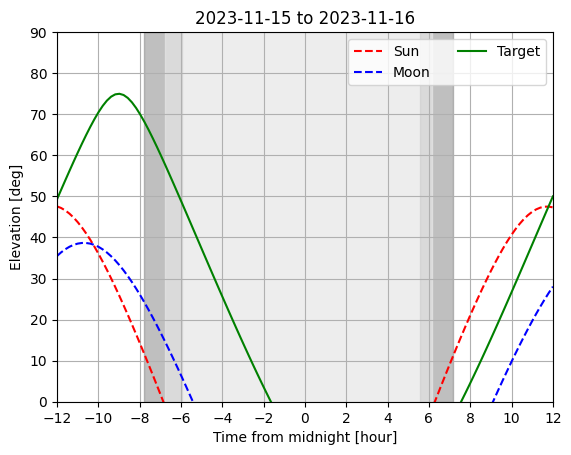

In [12]:
coord = co.SkyCoord(ra='18h36m56.3s', dec='38d47m01s', unit=(u.hourangle, u.deg)) # M 1

best_times_day(coord, lat=23.8, lon=90.4, utcoff=6., date='2023-11-16', plot=True, show=True, \
               distsun=90, distmoon=90, elev=50, night=True)


## Best time year

In [17]:
def best_times_year(c, year=2023, lat=24.3746, lon=88.6004, utcoff=2., delta=15, elev=20., night=False, show=True, \
    filename='auspiciousness_year.png', distsun=5, distmoon=3):
    start = datetime.strptime(str(year)+'-1-1', "%Y-%m-%d")
    stop = datetime.strptime(str(year+1)+'-1-1', "%Y-%m-%d")
    goods = []
    while start < stop:
        print(start.year, start.month, start.day)
        g = best_times_day(c, lat=lat, lon=lon, utcoff=utcoff, date=start, plot=False, elev=elev, night=night, distsun=distsun,distmoon=distmoon)
        goods.append(g)
        start = start + timedelta(days=delta)

    TR, TT = [], []
    delta_time = np.linspace(0, 24, 120)*u.hour
    for i in range(len(goods)):
        g = goods[i]
        try:
            TR.append((g[-1]-g[0]).value)
            TT.append((len(g)-1.)/len(delta_time)*24.)
        except:
            TR.append(None)
            TT.append(None)
    TT = np.array(TT)
    days = np.linspace(1, 366, len(TT))
    fig = plt.figure(figsize=(10,4))
    plt.plot(days, TT, 'r.:', markersize=10, alpha=0.5)
    #ind = np.where(np.logical_and(TT>=3.0,np.array(TR)<4.3))
    #plt.plot(days[ind], np.array(TR)[ind], 'g.', markersize=3, alpha=0.5)

    plt.xticks([1,31,59,90,120,151,181,212,243,273,304,334,365],\
            ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov','Dec',''])
    plt.xlim(0,366)
    plt.ylim(0,4.)
    plt.ylabel('Good times [hour]')
    plt.title("%s (%i)"%(c.to_string('hmsdms'),year))
    plt.grid()

    if show: plt.show()
    else: plt.tight_layout(); plt.savefig(filename, dpi=80)


In [19]:
best_times_year(c, year=2023, lat=24.3746, lon=88.6004, utcoff=6., delta=2, elev=50., \
                night=True, show=True, distsun=10, distmoon=90)


NameError: ignored

# Using package `Astroplan` to find শুভরাত

In [7]:
pip install astroplan

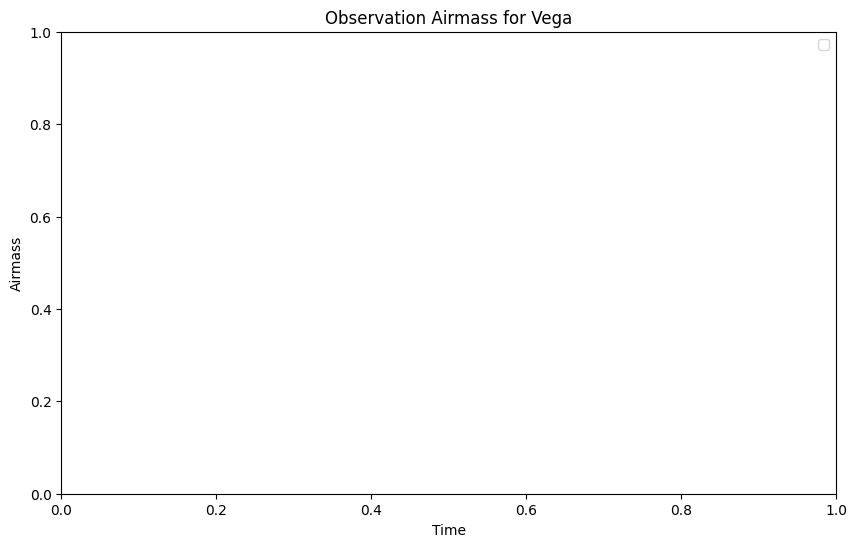

In [20]:
from astroplan import Observer, FixedTarget
from astropy.time import Time
import matplotlib.pyplot as plt
from astroplan.plots import plot_airmass
import astropy.units as u

# Specify the observer's location (latitude, longitude, elevation)
# For example, an observatory in New York City
observer = Observer(longitude=88.6004*u.deg, latitude=24.3746*u.deg, elevation=10*u.m)

# Specify the target star (RA, Dec)
# For example, Vega's coordinates
vega = FixedTarget.from_name("Vega")

# Specify the date range for observations
start_time = Time("2023-11-01 00:00:00")  # Start date
end_time = Time("2023-12-01 00:00:00")    # End date

# Calculate the observing window for the target star
observing_range = observer.target_rise_time(start_time, vega).iso, observer.target_set_time(start_time, vega).iso

# Plot the airmass of the target over the observing window
plt.figure(figsize=(10, 6))
plot_airmass(vega, observer, start_time, end_time)
plt.title("Observation Airmass for Vega")
plt.xlabel("Time")
plt.ylabel("Airmass")
plt.legend(loc='best')
plt.show()
